In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from importlib import reload


import config, data, models, train, evaluate

In [31]:
fig_dir = Path("/nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/masked_assimilation/_figures")
fig_dir.mkdir(exist_ok=True, parents=True)

exp_dict = {
    'ERA5 only': Path("/nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/masked_assimilation/e5_20250819_134749"),
    # '+ SWOT Reach': Path("/nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/masked_assimilation/e5_sr_20250819_134749"),
    # '+ SWOT Lake': Path("/nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/source_experiments/e5_sl_20250817_170311"),
    '+ GLOW-S': Path("/nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/masked_assimilation/e5_gs_20250819_134745"),
    '+ SWOT': Path("/nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/masked_assimilation/e5_sr_sl_20250819_134748"),
    'All': Path("/nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/masked_assimilation/e5_sr_sl_gs_20250819_134746")
}


exp_names = []
results = []
bulk_metrics = []
basin_metrics = []
predict_results = []
for exp_name, exp_dir in exp_dict.items():
    exp_names.append(exp_name)
    with open(exp_dir / "test_data.pkl", 'rb') as f:
        r, bulk_m, basin_m = pickle.load(f)
        
        for feat in basin_m.columns.get_level_values('Feature').unique():
            lt10 = basin_m[feat]['num_obs'] < 10
            basin_m.loc[lt10, feat] = np.nan
        
        results.append(r)
        bulk_metrics.append(bulk_m)
        basin_metrics.append(basin_m)

results = [results[0], pd.concat(results[1:],axis=1)]
# basin_metrics = [basin_metrics[0], pd.concat(basin_metrics[1:],axis=1)]
tmp = {}
[tmp.update(m) for m in bulk_metrics[1:]]
bulk_metrics = [bulk_metrics[0], tmp]


# Define colors and styles
e5_color = 'tab:blue'
reach_color = 'tab:orange'
lake_color = 'tab:green'
glow_color = 'tab:red'
rl_color = 'tab:purple'
all_color = 'black'

line_styles = [
    (e5_color,'-'),
    # (reach_color,'-'),
    # (lake_color, '-'),
    (glow_color, '-'),
    (rl_color, '-'),
    (all_color, '-')
]

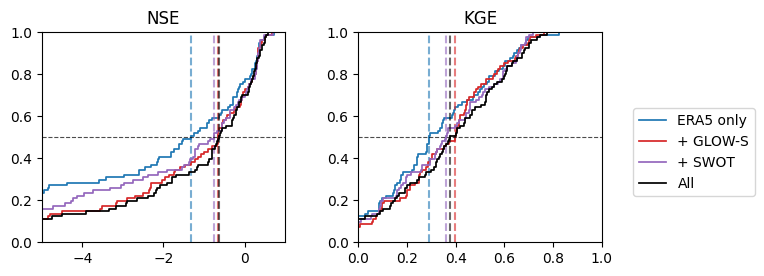

In [55]:
plt.close('all')

num_models = len(results)

colors = [t[0] for t in line_styles]
lines = [t[1] for t in line_styles]

metric_names = {
    # 'RE':'RE [%](higher is better)', 
    # 'R2': 'R² (lower is better)',
    'NSE': 'NSE',
    'KGE': 'KGE'
}

fig, axes = plt.subplots(1, 2, figsize=(8, 3))#, constrained_layout=True)
axes = axes.flatten()

for ax, (name, title) in zip(axes, metric_names.items()):
    for m_df, exp_name, (color, line) in zip(basin_metrics, exp_names, line_styles):
        x = np.array(m_df['discharge'][name], dtype=float)
        x = x[~np.isnan(x)]
        ax.ecdf(x, color=color, linestyle=line, linewidth=1.25, label=exp_name)

        # Median (50th percentile)
        median_val = np.percentile(x, 50)
        # Draw vertical line at median
        ax.axvline(median_val, color=color, linestyle="--", alpha=0.6)
        
    # Add horizontal 50% line
    ax.axhline(0.5, color="k", linestyle="--", linewidth=0.8, alpha=0.7)
    
    ax.set_title(title)

# axes[0].set_xlim([0, 250])
# axes[1].set_xlim([0, 1])
axes[0].set_xlim([-5, 1])
axes[1].set_xlim([0, 1])

handles, labels = ax.get_legend_handles_labels()

fig.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.9, wspace=0.3, hspace=0.4)
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1, 0.5))

# fig.tight_layout()
plt.show()

fig.savefig(fig_dir / f"ABC_cdfs_lines.png", dpi=300)

In [ ]:
plt

In [ ]:
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, 0.025))
plt.show()

In [ ]:
plt.close('all')

metric_args = {
    'RE': {'range':[0,400]},
    'R2':{'range':[-1,1]},
    'KGE':{'range':[-1,1]},
    
    }

feature_labels = ['SSC', 'SSF']
features = ['ssc', 'flux']
nRows = len(features)
nCols = len(metric_args)
fig, axes = plt.subplots(nRows, nCols, figsize=(6, 3))

for feature, axes_row in zip(features, axes):
    for (metric, metric_kwargs), ax in zip(metric_args.items(), axes_row):
        for m, (c, s) in zip(basin_metrics, line_styles):
            if (feature, metric) not in m:
                continue
            x = m[feature, metric].astype(float)
            x = x[np.isfinite(x)]
            
            if 'bias' in metric.lower():
                x = np.abs(x)
                
            ax.ecdf(x, color=c, linestyle=s, linewidth=1.25)
        
        # ax.set_aspect(1./ax.get_data_ratio())
        ax.set_xlim(metric_kwargs['range'])
        ax.set_ylim([0,1])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
# Top Axes
for metric, ax in zip(['RE','R²','KGE'], axes[0,:]):
    ax.set_title(metric, fontsize=14)
    
# Bottom Axes
for ax in axes[-1,:]:
    ax.set_xticks(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3))
    ax.set_xticklabels([int(label) for label in np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3)])
    
# Left Axes
for label, ax in zip(feature_labels, axes[:,0]):
    ax.set_ylabel(label, rotation=0, ha='right', fontsize=14, labelpad=8)
    ax.set_yticks(np.linspace(0, 1, 3))
    ax.set_yticklabels([f"{lab:0.2f}" for lab in np.linspace(0, 1, 3)])
    

# Adjust spacing to make room for the legend
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.15, right=0.75)

fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.77, 0.5))


# fig.tight_layout()
plt.show()

fig.savefig(fig_dir / "multitask_ablation_cdfs.png",  dpi=300)

In [ ]:
avg_dt = results[0]['dt']['landsat'].groupby(level='basin').mean().values
RE_change = (basin_metrics[0]['flux']['RE']- basin_metrics[2]['flux']['RE']).values.astype(float)

In [ ]:
results[0]

In [ ]:
plt.close('all')
plt.scatter(avg_dt,np.sign(RE_change))

In [ ]:
basin_metrics[0]['flux']['RE'].values.astype(float)

In [ ]:
np.sign(RE_change)

In [ ]:
def hexbin_1to1(ax, x, y, target, target_label, max_val, unit):
    positive_mask = (x > 0) & (y > 0)
    x = x[positive_mask]
    y = y[positive_mask]

    min_val = 5E-1
    log_min = np.log10(min_val)
    log_max = np.log10(max_val)

    hb = ax.hexbin(x, y, gridsize=(30,20), bins='log', mincnt=5,
                linewidth=0.2,
                extent=(log_min, log_max, log_min, log_max),
                xscale='log', yscale='log')
    plt.colorbar(hb, shrink=0.6, aspect=10, anchor=(0,0.5))

    # Add a 1:1 line over the min and max of x and y
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')

    # Setting axes to be square and equal range
    ax.axis('square')
    ax.set_xlim(min_val, max_lim)
    ax.set_ylim(min_val, max_lim)
    ax.set_title(f"{target_label} (n {len(x):,})")
    ax.set_xlabel(f'Observed ({unit})')
    ax.set_ylabel(f'Predicted ({unit})')

    

targets = ['ssc','flux','usgs_q']
target_labels = ['SSC', 'SSF', 'Q']
units = ['mg/l', 'T/d', 'm³/s']
max_lims = [5E5, 5E6, 1E5]

fig, axes = plt.subplots(1,len(targets), figsize=(len(targets)*3, 3))

idx_plot = 0
axes = [axes] if len(targets)==1 else axes        
for target, target_label, unit, max_lim, ax in zip(targets, target_labels, units, max_lims, axes):
    dt_mask = results[idx_plot]['dt'].max(axis=1) >= 0
    x = results[idx_plot]['obs'][target]
    y = results[idx_plot]['pred'][target]
    hexbin_1to1(ax, x[dt_mask], y[dt_mask], target, target_label, max_lim, unit)

plt.tight_layout()

# fig.savefig(fig_dir / f"bulk_scatterplots.png", dpi=300)

In [ ]:
bulk_metrics[0]

In [ ]:
import sklearn.metrics as skm

def get_log_r2(df):
    x = df['obs']['flux']
    y = df['pred']['flux']
    positive_mask = (x > 0) & (y > 0)
    x = x[positive_mask]
    y = y[positive_mask]
    
    if len(x) > 10:
        return skm.r2_score(np.log10(x),np.log10(y))
    else:
        return np.nan

r2 = results[0].groupby(level='basin').apply(get_log_r2)
r2.median()

In [ ]:
basin_metrics[0]['flux']

In [ ]:
import evaluate
evaluate.get_all_metrics(results[0][dt_mask])

In [ ]:
cfg = {'step_kwargs':{'aaa':1, 'bbb':2}}
cfg.get('target_weights',{}).get('ssc', 1)

In [ ]:
matchups

In [ ]:
plt.close('all')
sites[metric].hist()

In [ ]:
from matplotlib.colors import Normalize


sites = pd.read_csv('/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/preprocess/hydrography_matchups.csv',index_col='wqp_id')
geom = gpd.GeoSeries.from_wkt(sites.geometry)
sites = gpd.GeoDataFrame(sites, geometry = geom)

var = 'flux'
metric = 'RE'

sites = sites.merge(basin_metrics[0][var][metric], left_index=True, right_index=True)
sites[metric] = sites[metric].astype(float)

plt.close('all')

# Create a plot with GeoPandas
fig, ax = plt.subplots(figsize=(8, 3))

# Define the normalization from -1 to 1
# norm = Normalize(vmin=-1, vmax=1)
# cmap = 'RdYlBu'

norm = Normalize(vmin=0, vmax=400)
cmap = 'inferno'

# Plot the data, specifying 'KGE' as the column, and applying the colormap and normalization
sites.plot(column=metric, cmap=cmap, norm=norm, markersize=20, ax=ax)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array to avoid warnings
cbar = fig.colorbar(sm, ax=ax)

# Optional: Set colorbar label
cbar.set_label(f'{metric} Values', fontsize=12)

plt.show()